Training Lifelong PG-RL...
Testing Lifelong PG-RL (with online adaptation)...


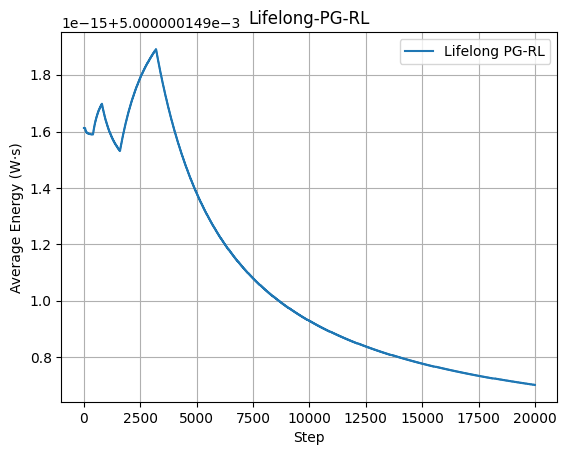

In [4]:
# Comparison of Lyapunov, PG-RL, and Lifelong PG-RL with GPU Support
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Lasso
from sklearn.preprocessing import normalize
import time
import pandas as pd

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------- Environment ----------------------------
class WSNEnvFixed:
    def __init__(self):
        self.NumberTxs = 2
        self.Bandwidth = 5e6
        self.NoisePowerWatt = 10**(-120 / 10) / 1000
        self.Tx0MaxPowerWatt = 0.03
        self.BatteryCapacityJoul = 0.1
        self.ArrivalDataRate = 5
        self.ComChannScale = 1.0
        self.EHChannScale = 1.0
        self.EHPowerConversionEffi = 0.1
        self.reset()

    def reset(self):
        self.queues = np.zeros(self.NumberTxs)
        self.batteries = np.zeros(self.NumberTxs - 1)
        self.CommChannGain = np.random.rayleigh(scale=self.ComChannScale, size=self.NumberTxs)
        self.EHChannGain = np.random.rayleigh(scale=self.EHChannScale, size=1)
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.queues, self.batteries, self.CommChannGain, self.EHChannGain])

    def step(self, action):
        Tx0Power, Tx0CommTime, Tx1CommTime, EHTime = action
        Arrivals = np.random.poisson(self.ArrivalDataRate, self.NumberTxs)
        Tx0TransmitData = self.Bandwidth * np.log2(1 + (Tx0Power * self.CommChannGain[0]) / self.NoisePowerWatt) * Tx0CommTime
        Tx0TransmitData = float(min(Tx0TransmitData, self.queues[0]))
        Tx1Power = (self.batteries / EHTime).item()
        Tx1Rate = self.Bandwidth * np.log2(1 + (Tx1Power * self.CommChannGain[1]) / self.NoisePowerWatt)
        Tx1TransmitData = float(min(Tx1Rate * Tx1CommTime, self.queues[1]))
        HarvestedPow = self.EHPowerConversionEffi * (self.Tx0MaxPowerWatt - Tx0Power) * self.EHChannGain
        self.queues = np.maximum(self.queues - np.array([Tx0TransmitData, Tx1TransmitData]), 0) + Arrivals
        self.batteries = np.maximum(self.batteries - (Tx1Power * Tx1CommTime), 0) + (HarvestedPow * EHTime)
        self.CommChannGain = np.random.rayleigh(scale=self.ComChannScale, size=self.NumberTxs)
        self.EHChannGain = np.random.rayleigh(scale=self.EHChannScale, size=1)
        energy = (Tx0Power * Tx0CommTime) + (Tx1Power * Tx1CommTime)
        reward = -energy
        return self._get_state(), reward, False, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime

class WSNEnv(WSNEnvFixed):
    def update_conditions(self, step):
        if step == 10000:
            self.EHChannScale = 3.0
            self.EHPowerConversionEffi = 0.3

class WSNEnvLifelong(WSNEnvFixed):
    def update_conditions(self, step):
        if step == 10000:
            self.EHChannScale = 2
            self.EHPowerConversionEffi = 0.2

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)


def flatten_params(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_params(model, flat_params):
    idx = 0
    for p in model.parameters():
        sz = p.numel()
        p.data.copy_(flat_params[idx:idx+sz].view_as(p))
        idx += sz


# ------------------------ Lifelong RL Core --------------------------
def lifelong_train(env, num_tasks=2, task_len=10000):
    latent_dim = 10
    policy_example = PolicyNet(6, 4).to(device)
    N = flatten_params(policy_example).numel()
    G = torch.randn(N, latent_dim)
    X = torch.zeros(latent_dim, latent_dim)
    Y = torch.zeros(N, latent_dim)
    eta = 0.1

    for task in range(num_tasks):
        env.update_conditions(task * task_len)
        policy = PolicyNet(6, 4).to(device)
        optimizer = optim.Adam(policy.parameters(), lr=0.01)
        train_policy(env, policy, optimizer, episodes=task_len)

        beta = flatten_params(policy).cpu().numpy()
        beta = normalize(beta.reshape(1, -1))[0]
        G_np = normalize(G.numpy(), axis=0)

        if np.linalg.norm(beta) < 1e-8 or np.all(G_np == 0):
            v = torch.zeros(G_np.shape[1], dtype=torch.float32)
        else:
            try:
                lasso = Lasso(alpha=0.01, max_iter=10000, tol=1e-4, fit_intercept=False)
                lasso.fit(G_np, beta)
                v = torch.tensor(lasso.coef_, dtype=torch.float32)
            except Exception as e:
                print(f"Lasso failed at task {task}: {e}")
                v = torch.zeros(G_np.shape[1], dtype=torch.float32)

        beta_torch = torch.tensor(beta, dtype=torch.float32)
        X = (1 - eta) * X + eta * torch.ger(v, v)
        Y = (1 - eta) * Y + eta * torch.ger(beta_torch, v)
        G = torch.linalg.lstsq(X.T, Y.T).solution.T

    return G

def lifelong_adapt_and_learn(env, G, steps):
    state_dim, action_dim = 6, 4
    policy = PolicyNet(state_dim, action_dim).to(device)
    energy_trace = []
    optimizer = optim.Adam(policy.parameters(), lr=0.01)

    for step in range(steps):
        env.update_conditions(step)
        state = env.reset()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        with torch.no_grad():
            beta = flatten_params(policy).cpu().numpy()
            beta = normalize(beta.reshape(1, -1))[0]
            G_np = normalize(G.numpy(), axis=0)

            if np.linalg.norm(beta) < 1e-8 or np.all(G_np == 0):
                v = torch.zeros(G_np.shape[1], dtype=torch.float32)
            else:
                try:
                    lasso = Lasso(alpha=0.01, max_iter=10000, tol=1e-4, fit_intercept=False)
                    lasso.fit(G_np, beta)
                    v = torch.tensor(lasso.coef_, dtype=torch.float32)
                except Exception as e:
                    print(f"Lasso failed at step {step}: {e}")
                    v = torch.zeros(G_np.shape[1], dtype=torch.float32)

            beta_new = torch.matmul(G, v)
            set_params(policy, beta_new.to(device))

        action = policy(state_tensor).detach().cpu().numpy()
        Tx0Power = action[0] * env.Tx0MaxPowerWatt
        time_split = action[1:] / np.sum(action[1:])
        Tx0CommTime, EHTime, Tx1CommTime = time_split
        action_vec = [Tx0Power, Tx0CommTime, Tx1CommTime, EHTime]
        _, reward, _, Tx0Power, Tx0CommTime, Tx1Power, Tx1CommTime = env.step(action_vec)

        optimizer.zero_grad()
        output = policy(state_tensor)
        target = torch.tensor(action, dtype=torch.float32, device=device)
        loss = -((output - target) ** 2).mean() * reward
        loss.backward()
        optimizer.step()

        energy = Tx0Power * Tx0CommTime + Tx1Power * Tx1CommTime
        energy_trace.append(energy)

    return energy_trace
    
if __name__ == "__main__":
    steps = 20000

    print("Training Lifelong PG-RL...")
    env_train_Lifelong_PG_RL = WSNEnv()
    G = lifelong_train(env_train_Lifelong_PG_RL, num_tasks=2, task_len=10000)
    
    print("Testing Lifelong PG-RL (with online adaptation)...")
    env_test_Lifelong_PG_RL = WSNEnvLifelong()
    energy_l2rl = lifelong_adapt_and_learn(env_test_Lifelong_PG_RL, G, steps)
    
    plt.figure()
    plt.plot(np.cumsum(energy_l2rl)/np.arange(1, steps+1), label="Lifelong PG-RL")
    plt.title("Lifelong-PG-RL")
    plt.xlabel("Step")
    plt.ylabel("Average Energy (W·s)")
    plt.legend()
    plt.grid(True)

    plt.show()
